### Downloading the data

In [4]:
import numpy as np
import pandas as pd

# Przygotowanie danych
splits_1 = {'train': 'train.csv', 'validation': 'dev.csv', 'test': 'test.csv'}
df_1 = pd.read_csv("hf://datasets/Adapting/empathetic_dialogues_v2/" + splits_1["train"])

splits_2 = {'train': 'train.jsonl', 'validation': 'validation.jsonl', 'test': 'test.jsonl'}
df_2 = pd.read_json("hf://datasets/SetFit/emotion/" + splits_2["train"], lines=True)

df_1.drop(columns=['id', 'chat_history', 'sys_response', 'question or not', 'behavior'], inplace=True)
df_2.drop(columns=['label'], inplace=True)

df_1.rename(columns={'situation': 'text'}, inplace=True)
df_2.rename(columns={'label_text': 'emotion'}, inplace=True)

combined_df = pd.concat([df_1, df_2])
combined_df

,text,emotion
0,I have always been a big fan of childrens plac...,faithful
1,I am piss-off,angry
2,I am feeling happy I can afford what I need fo...,joyful
3,I saw my friend projectile vomit on the roller...,disgusted
4,I was very happy when I got to see my aunt at ...,grateful
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Exploring and cleaning the data

In [9]:
# Sprawdzenie brakujących wartości
print("Brakujące wartości w kolumnach:\n", combined_df.isnull().sum())

# Usunięcie wierszy z brakującymi wartościami (jeśli istnieją)
combined_df.dropna(inplace=True)

# Sprawdzenie duplikatów i ich usunięcie
print("Liczba duplikatów przed usunięciem:", combined_df.duplicated(subset=['text']).sum())
combined_df.drop_duplicates(subset=['text'], inplace=True)
print("Liczba duplikatów po usunięciu:", combined_df.duplicated(subset=['text']).sum())

# Sprawdzenie wyników po czyszczeniu danych
print(combined_df.head())
print("Liczba wierszy po czyszczeniu:", len(combined_df))


Brakujące wartości w kolumnach:
 text       0
emotion    0
dtype: int64
Liczba duplikatów przed usunięciem: 21088
Liczba duplikatów po usunięciu: 0
                                                                                                                         text  \
0                                            I have always been a big fan of childrens place, I will never shop anywhere else   
1                                                                                                               I am piss-off   
2  I am feeling happy I can afford what I need for the past few months. It's nice to be able to get something if you need it.   
3                                         I saw my friend projectile vomit on the rollercoaster. The smell still haunts me...   
4                                   I was very happy when I got to see my aunt at Christmas. I had no seen her in a long time   

     emotion  
0   faithful  
1      angry  
2     joyful  
3  disgusted  
4 

### Model training

In [5]:
import torch
print("Czy CUDA jest dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

torch.set_float32_matmul_precision('medium')

Czy CUDA jest dostępna: False
Nazwa GPU: Brak GPU


In [6]:
from autogluon.multimodal import MultiModalPredictor
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# predictor = MultiModalPredictor(label='emotion')
# predictor.fit(train_df)
predictor = MultiModalPredictor.load("AutogluonModels/ag-20241112_165247/model.ckpt")

Loading checkpoint: 'C:\Users\s24916\DataspellProjects\SUML_Emotions\AutogluonModels\ag-20241112_165247\model.ckpt'


### Evaluating model

In [ ]:
performance = predictor.evaluate(test_df)
print("Wyniki modelu:\n", performance)

C:\Users\s24916\.conda\envs\SUML_Emotions\lib\site-packages\autogluon\multimodal\utils\environment.py:62: UserWarning: Using the detected GPU number 0, smaller than the GPU number 1 in the config.
  warnings.warn(


Predicting DataLoader 0: 100%|██████████| 352/352 [07:06<00:00,  0.82it/s]
              precision    recall  f1-score   support

      afraid       0.83      0.82      0.82       263
       anger       0.93      0.95      0.94       439
       angry       0.83      0.87      0.85       294
     annoyed       0.88      0.91      0.89       286
anticipating       0.86      0.87      0.86       245
     anxious       0.87      0.89      0.88       235
apprehensive       0.88      0.90      0.89       175
     ashamed       0.86      0.86      0.86       181
      caring       0.91      0.98      0.95       212
   confident       0.94      0.92      0.93       244
     content       0.92      0.92      0.92       244
  devastated       0.88      0.87      0.87       240
disappointed       0.82      0.91      0.86       232
   disgusted       0.90      0.97      0.94       260
 embarrassed       0.94      0.92      0.93       251
     excited       0.88      0.88      0.88       319
    fa

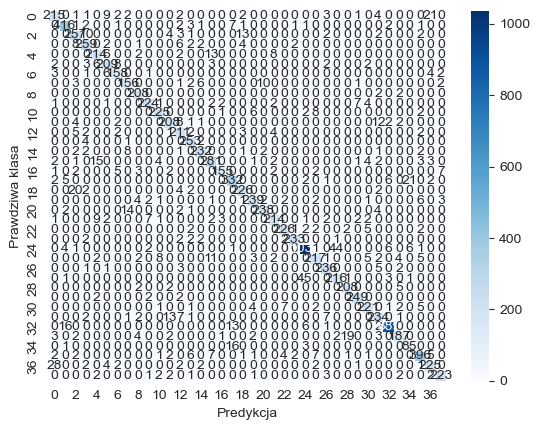

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = predictor.predict(test_df[['text']])
y_true = test_df['emotion']
                                                                         
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.show()